<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Large-scale-text-analysis-with-deep-learning-(3-points)" data-toc-modified-id="Large-scale-text-analysis-with-deep-learning-(3-points)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Large scale text analysis with deep learning (3 points)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#About-the-challenge" data-toc-modified-id="About-the-challenge-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>About the challenge</a></span></li><li><span><a href="#Preprocessing-text-data" data-toc-modified-id="Preprocessing-text-data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Preprocessing text data</a></span></li><li><span><a href="#The-deep-learning-part" data-toc-modified-id="The-deep-learning-part-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>The deep learning part</a></span><ul class="toc-item"><li><span><a href="#Architecture" data-toc-modified-id="Architecture-1.0.3.1"><span class="toc-item-num">1.0.3.1&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Training-and-evaluation" data-toc-modified-id="Training-and-evaluation-1.0.3.2"><span class="toc-item-num">1.0.3.2&nbsp;&nbsp;</span>Training and evaluation</a></span></li></ul></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Bonus-part:-explaining-model-predictions" data-toc-modified-id="Bonus-part:-explaining-model-predictions-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Bonus part: explaining model predictions</a></span></li></ul></li></ul></li></ul></div>

# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
# !curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
# !tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

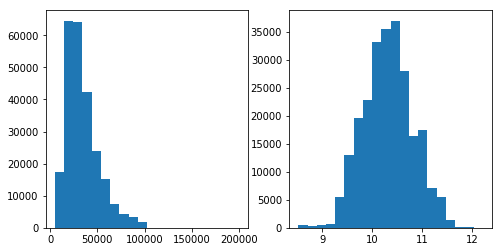

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
232073,72460915,ALM WithProfits Support Actuary,Our client is seeking an actuarial expert to t...,South East,South East London,NaN,permanent,Star Actuarial Futures,Accounting & Finance Jobs,up to 80k + bonus + benefits,80000,actuaryjobs.co.uk,11.289794
194297,71793372,Activities Assistant,To assist residents with breakfast and interac...,Southport,Southport,part_time,NaN,NaN,Healthcare & Nursing Jobs,4.98 - 6.19 per hour MEETS NMW,10723,Jobcentre Plus,9.280239
81523,69027168,IT Vendor Manager,We are currently seeking an experienced Vendor...,"Bromley, England",Bromley,NaN,NaN,NaN,IT Jobs,50000,50000,britishjobsonthe.net,10.819798


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

# see task above
data.FullDescription = data.FullDescription.fillna('').str.lower().apply(tokenizer.tokenize).apply(' '.join)
data.Title = data.Title.fillna('').str.lower().apply(tokenizer.tokenize).apply(' '.join)

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
from itertools import chain

# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
token_counts = Counter(chain.from_iterable(data.FullDescription.str.split()))
token_counts.update(Counter(chain.from_iterable(data.Title.str.split())))

# hint: you may or may not want to use collections.Counter

In [10]:
token_counts.most_common(10)

[('and', 2657388),
 ('.', 2523216),
 (',', 2318606),
 ('the', 2080994),
 ('to', 2019884),
 ('a', 1521925),
 ('of', 1426213),
 ('in', 1035792),
 ('for', 867233),
 ('with', 728884)]

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('improvemen', 1)
('techniciancivil', 1)
('mlnlycke', 1)
Correct!


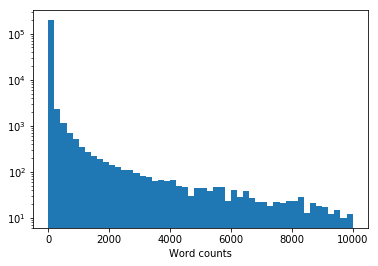

In [12]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Now filter tokens a list of all tokens that occur at least 10 times.

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [k for k, v in token_counts.items() if v >= min_count]

In [14]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [15]:
token_to_id = {tok: idx for idx, tok in enumerate(tokens)}

In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [18]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [19]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [21]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [23]:
import keras
import keras.layers as L

In [86]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")

    # Build your monster!
    
    emb_size = 50

    l_title_emb  = L.Embedding(n_tokens, emb_size)(l_title)
    l_title_conv = L.Conv1D(5, emb_size, padding='same')(l_title_emb)
    l_title_pool = L.GlobalMaxPool1D()(l_title_conv)
    # l_title_flat = L.Flatten()(l_title_pool)

    l_descr_emb  = L.Embedding(n_tokens, emb_size)(l_descr)
    l_descr_conv = L.Conv1D(5, emb_size, padding='same')(l_descr_emb)
    l_descr_pool = L.GlobalMaxPool1D()(l_descr_conv)
    # l_descr_flat = L.Flatten()(l_descr_pool)

    l_categ_dens = L.Dense(64)(l_categ)

    concat = L.Concatenate()([l_title_pool, l_descr_pool, l_categ_dens])
    hid = L.Dense(hid_size)(concat)
    output_layer = L.Dense(1)(hid)
    # end of your code

    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])




#     """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
#     l_title = L.Input(shape=[None], name="Title")
#     l_descr = L.Input(shape=[None], name="FullDescription")
#     l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
#     # Build your monster!
    
    
    
#     # <YOUR CODE>
    
#     output_layer = <...>
#     # end of your code
    
#     model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
#     model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [87]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Title (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
FullDescription (InputLayer)    (None, None)         0                                            
__________________________________________________________________________________________________
embedding_56 (Embedding)        (None, None, 50)     1707900     Title[0][0]                      
__________________________________________________________________________________________________
embedding_57 (Embedding)        (None, None, 50)     1707900     FullDescription[0][0]            
__________________________________________________________________________________________________
conv1d_54 

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [88]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [89]:
batch_size = 256
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10
100/100 [==============================] - 1237s 12s/step - loss: 17.9129 - mean_absolute_error: 2.6154 - val_loss: 0.3341 - val_mean_absolute_error: 0.4577
Epoch 2/10
100/100 [==============================] - 1199s 12s/step - loss: 0.2279 - mean_absolute_error: 0.3728 - val_loss: 0.1628 - val_mean_absolute_error: 0.3133
Epoch 3/10
100/100 [==============================] - 1197s 12s/step - loss: 0.1408 - mean_absolute_error: 0.2889 - val_loss: 0.1168 - val_mean_absolute_error: 0.2610
Epoch 4/10
100/100 [==============================] - 1245s 12s/step - loss: 0.1083 - mean_absolute_error: 0.2508 - val_loss: 0.1007 - val_mean_absolute_error: 0.2402
Epoch 5/10
100/100 [==============================] - 1262s 13s/step - loss: 0.0957 - mean_absolute_error: 0.2328 - val_loss: 0.0889 - val_mean_absolute_error: 0.2240
Epoch 6/10
100/100 [==============================] - 1312s 13s/step - loss: 0.0874 - mean_absolute_error: 0.2221 - val_loss: 0.0822 - val_mean_absolute_error: 0.21

In [90]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

Train results:
Mean square error: 0.06470
Mean absolute error: 0.18816
Val results:
Mean square error: 0.07658
Mean absolute error: 0.20624


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [91]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [92]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [93]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [94]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [152]:
data.columns

Index(['Id', 'Title', 'FullDescription', 'LocationRaw', 'LocationNormalized',
       'ContractType', 'ContractTime', 'Company', 'Category', 'SalaryRaw',
       'SalaryNormalized', 'SourceName', 'Log1pSalary'],
      dtype='object')

In [154]:
i = np.random.randint(len(data))
print("Index:", i)
print("[PRED]: Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))
print("[TRUE]: Salary (gbp):", data.loc[i, 'SalaryNormalized'])

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 184180
[PRED]: Salary (gbp): 17840.217
[TRUE]: Salary (gbp): 62499


it audit manager ( avp )

it audit senior it auditor banking internal audit fs london **** k **** k i am currently seeking an it auditor to join a prestigious investment bank at the senior it auditor level based in london . this is a fantastic opportunity for the successful applicant to join a top performing team in both the it auditing and financial services sector . the core responsibilities of the role include : constructing annual audit plans in accordance with the relevant policies , procedures and to a high standard of quality , include identifying , assessing and documenting risk and controls , evaluating the design and operating effectiveness of controls providing suggestions to management on how to address any control issues that have been discovered . for this it audit senior role , the perfect candidate will already have 2 years experience in risk based auditing , with a strong background in investment banking , either within a big 4 or internal audit environment . in addition , a proven technical knowledge and record of high performance in previous roles as well as the relevant qualifications , including cisa , are preferred . to find out more about real please visit www . realstaffing . com

In [98]:
case = data.loc[i].copy()

In [100]:
case.Title

'italian speaking customer support manager'

In [135]:
case.Title = 'data engineer'
case.FullDescription = "not so much info here"

In [136]:
print("Salary (gbp):", np.expm1(model.predict(make_batch(case.to_frame().T))[0, 0]))

tokens_and_weights_title = explain(model, case, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights_title], font_style='font-size:20px;');

tokens_and_weights_descr = explain(model, case, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights_descr]);

Salary (gbp): 591.87665


data engineer

not so much info here

In [137]:
pd.concat((pd.DataFrame(tokens_and_weights_title), pd.DataFrame(tokens_and_weights_descr)))

,0,1
0,data,-0.023366
1,engineer,-0.025332
0,not,-0.022086
1,so,-0.001782
2,much,0.017561
3,info,-0.019735
4,here,0.037857


In [103]:
print("Salary (gbp):", np.expm1(model.predict(make_batch(case.to_frame().T))[0, 0]))

tokens_and_weights = explain(model, case, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, case, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Salary (gbp): 4506.908


italian speaking customer support manager

baltic recruitment are currently looking to recruit a native italian speaker who has a stong knowledge of online gaming , excellent customer service skills and experience in dealing with technical queries . fluency in english , italian native experience in free to play games experience working with online communities strong communication skills experience with online and offline events familiar with social media and social media communication strategies familiar with rules of conduct , UNK and moderation familiar with cms ( e . g . drupal ) and forum software familiar with microsoft office core competencies and key responsibilities community building by human communication and interaction with the community information distribution from the company to the community in a clear , consistent manner feedback gathering from the community for game design , development team and management working closelyknit with the support to streamline outgoing communication plan and execute content for all platforms ( website , facebook , youtube , twitter , forum ) together with marketing and game mastering strategic community planning and moderation management plan and execute event concepts online and offline preferred additional experience passionate about online gaming additional languages uptodate on online and offline trends this role is a part time role with a view to going full time

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)